**This Notebook goes along with convnet_devp1.py. It records the experimental convnet tuning process using a small batch of fixed data and using MiniBatch Gradient Descent Optimizer**

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from convnet_devp1 import *

/Users/Zhongyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## The CIFAR-10 Dataset
***
#### Dataset Overview
- The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
- The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 
- There are 10 classes in the dataset. The classes are completely mutually exclusive. 
 - airplane										
 - automobile										
 - bird										
 - cat										
 - deer										
 - dog										
 - frog										
 - horse										
 - ship										
 - truck
 
#### Datafile Overview
- data_batch_num & test_batch
    - data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
    - labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
- batches.meta
    - label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.
***

### Load Data

In [2]:
train_dataset, train_labels, test_dataset, test_labels = load_data()

Loading the training data...
Loading the testing data...


### Split Training and Validation

In [3]:
train_dataset, valid_dataset, train_labels, valid_labels = \
    train_test_split(train_dataset, train_labels, test_size=10000,\
    random_state=897, stratify=train_labels)

In [4]:
print 'Dataset\t\tFeatureShape\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape,'\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape	LabelShape
Training set:	(40000, 3072) 	(40000,)
Validation set:	(10000, 3072) 	(10000,)
Testing set:	(10000, 3072) 	(10000,)


### Reshape Data - 32x32x3

In [5]:
train_dataset = np.rollaxis(train_dataset.reshape((-1,3,32,32)), 1, 4)
valid_dataset = np.rollaxis(valid_dataset.reshape((-1,3,32,32)), 1, 4)
test_dataset = np.rollaxis(test_dataset.reshape((-1,3,32,32)), 1, 4)
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


### Data Augmentation

In [6]:
# Visualize Data
meta_filename = "cifar-10-batches-py/batches.meta"
label_names = unpickle(meta_filename)['label_names']
print label_names[train_labels[3377]]
sample = train_dataset[3377, :, :, :]
#plt.imshow(sample);plt.show()

frog


In [7]:
# Mirror Reflection/Left-Right Flip the Input Data
train_LRF = train_dataset[:,:,::-1,:]
train_LRF.shape

(40000, 32, 32, 3)

In [8]:
# Verify and visualize the mirror reflection/Left-Right Flip
sample_LRF = train_LRF[3377,:,:,:]
#plt.imshow(sample_LRF);plt.show()

### Data Preprocess - Substract mean/Center data; Reduce datatype precision

In [8]:
# Dataset Parameters
image_size = 32
num_labels = 10
num_channels = 3

In [9]:
train_dataset, train_labels = preprocess_data(train_dataset, train_labels, num_labels)
valid_dataset, valid_labels = preprocess_data(valid_dataset, valid_labels, num_labels)
test_dataset,  test_labels  = preprocess_data(test_dataset,  test_labels,  num_labels)

### Setup Network Parameters

In [10]:
# Network parameters
batch_size = 64
kernel_size3 = 3
kernel_size5 = 5
num_filter = 16
fc_size1 = 256

In [11]:
# Setup shapes for each layer in the convnet
convnet_shapes = {'conv1' : [kernel_size5, kernel_size5, num_channels, num_filter],
                  'conv2' : [kernel_size3, kernel_size3, num_filter, num_filter],
                  'conv3' : [kernel_size5, kernel_size5, num_filter, num_filter],
                  'fc1'   : [(image_size/2/2/2)**2*num_filter, fc_size1],
                  'fc2'   : [fc_size1, num_labels]}

In [12]:
def generate_batch(features, labels, batch_size):
    # Generate a small batch of data
    start = np.random.randint(0, features.shape[0]-batch_size)
    feature_batch, label_batch = features[start:start+batch_size,:,:,:], labels[start:start+batch_size,:]
    return feature_batch, label_batch

In [13]:
def generate_hyperparams():
    # Generate random hyperparameters
    keep_prob = np.random.uniform(0.0, 1.0)#.astype(np.float32)
    init_mean = np.random.uniform(-0.001, 0.001)#.astype(np.float32)
    init_std = np.random.uniform(-0.1, 0.1)#.astype(np.float32)
    learning_rate = np.random.uniform(0.001, 0.1)
    hyperparams={'keep_prob': keep_prob, 'init_mean': init_mean, 'init_std': init_std, 'learning_rate': learning_rate}
    return hyperparams

In [1]:
def random_search(num_experiments, train_batch_size, valid_batch_size, convnet_shapes, epoch):
    experiment_data = {}
    for i in range(num_experiments):
        # Prepare small batch of data for experimental training
        print "Prepare small batch of data for experimental training", '.'*16
        train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
        valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)
        print 'Dataset\t\tFeatureShape\t\tLabelShape'
        print 'Training set:\t', train_batch.shape,'\t', train_label_batch.shape
        print 'Validation set:\t', valid_batch.shape,'\t', valid_label_batch.shape
        # Sample random HyperParameters
        print "Sample random HyperPrameters", '.'*16
        hyperparams = generate_hyperparams()
        # Prepare data for tensorflow
        print "Prepare data for tensorflow",'.'*16
        graph = tf.Graph()
        with graph.as_default():
            tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
                       'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
                       'test_X' : None, 'test_y': None}
        # Train convnet
        _, training_data = train_convnet(graph, tf_data, convnet_shapes, hyperparams, epoch, False)
        key = tuple(hyperparams.values())
        experiment_data[key] = training_data
        print "Finished experiment ", str(i)
        print "="*100
    return experiment_data

### Random Search through HyperParameter Spaces

In [15]:
num_exp = 20
train_batch_size = 64
valid_batch_size = 32
epoch = 1000

In [16]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare small batch of data for experimental training ................
Dataset		FeatureShape		LabelShape
Training set:	(64, 32, 32, 3) 	(64, 10)
Validation set:	(32, 32, 32, 3) 	(32, 10)
Sample random HyperPrameters ................
Prepare data for tensorflow ................
Prepare network parameters ................................
Start training ................................
Initialized
Training loss at step 0: 54.907642
Training accuracy: 6.2%
Validation loss at step 0: 574.448975
Validation accuracy: 21.9%
Training loss at step 500: 2.294525
Training accuracy: 14.1%
Validation loss at step 500: 2.318310
Validation accuracy: 6.2%
Finished training ................................
Finished experiment  0
Prepare small batch of data for experimental training ................
Dataset		FeatureShape		LabelShape
Training set:	(64, 32, 32, 3) 	(64, 10)
Validation set:	(32, 32, 32, 3) 	(32, 10)
Sample random HyperPrameters ................
Prepare data for tensorflow ................
P

### Analyze experimental data

In [2]:
def plot_data(data):
    epoch = range(data['train_losses'].shape[0])
    plt.subplot(211)
    plt.plot(epoch, data['train_losses'], label= 'training loss')
    plt.plot(epoch, data['valid_losses'], label='validation loss')
    plt.ylim([-.1,4])
    plt.legend(loc='upper right')
    plt.subplot(212)
    plt.plot(epoch, data['train_acc'], label='training accuracy')
    plt.plot(epoch, data['valid_acc'], label='validation accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='upper right')
    plt.show()

keep_prob		init mean		init std		learning rate		valid accuracy
0.518150343983 		-0.047290999365 	0.00891883021657 	-0.000170988040756 	0.34375


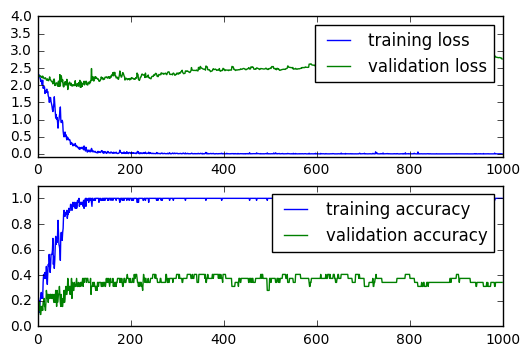

keep_prob		init mean		init std		learning rate		valid accuracy
0.596359014041 		0.0555895951485 	0.00873684128938 	0.000323258740462 	0.34375


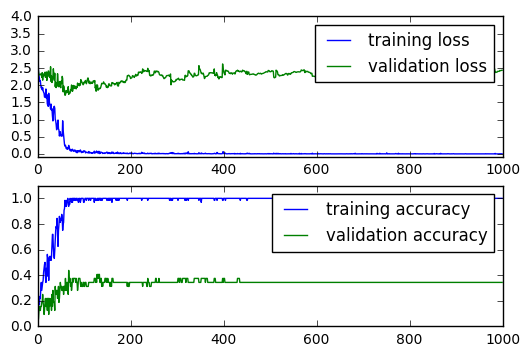

keep_prob		init mean		init std		learning rate		valid accuracy
0.61739506991 		0.07008711483 	0.00414030937969 	0.000559360505071 	0.3125


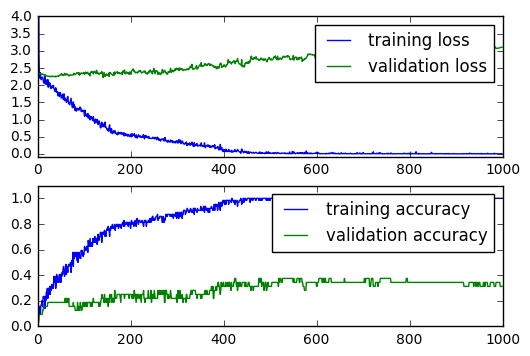

keep_prob		init mean		init std		learning rate		valid accuracy
0.353113243559 		0.0727668968042 	0.00994963024032 	-0.000940979429823 	0.34375


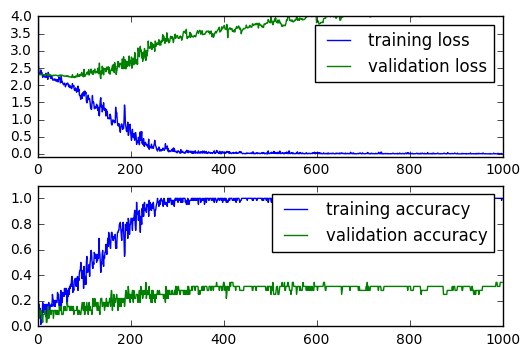

In [34]:
for key in experiment_data.keys():
    exp_data = experiment_data[key]
    if (exp_data['valid_acc'][499]>.25) and (exp_data['train_acc'][-1]>.95):
        print "="*110
        print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate\t\t', 'valid accuracy'
        print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t', exp_data['valid_acc'][999]
        plot_data(exp_data)

***
**Previous Experiments**

keep_prob		init mean		init std		learning rate
0.386402537001 		0.0671478655188 	0.00565559597859 	-0.00045892192093 	


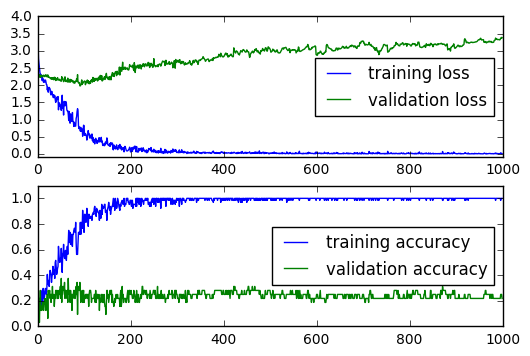

0.809876504698 		0.0827356922373 	0.00332049516983 	-0.000854942153922 	


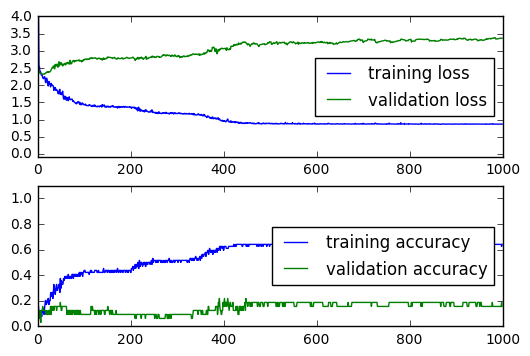

In [64]:
keys = experiment_data.keys()
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[0]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[1]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.00565559597859 		0.0671478655188 	0.00565559597859 	-0.00045892192093 	


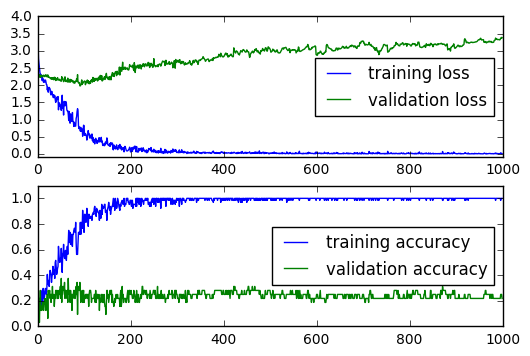

0.160957527021 		0.0668706267202 	0.00179491932632 	-0.000738359323427 	


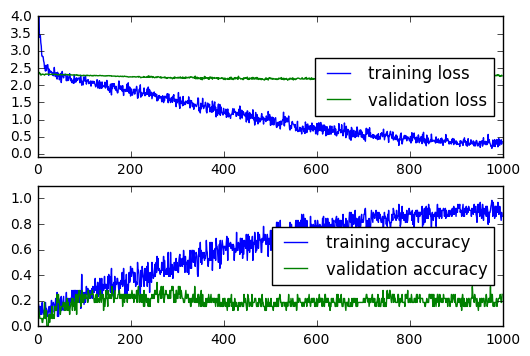

In [65]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[0]
print key[2],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[3]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.0887495167117 		-0.031462567738 	0.00910914215389 	-0.000965401944158 	


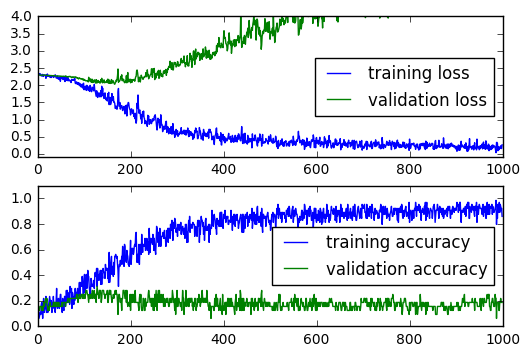

0.261917138064 		0.0349189337207 	0.00742819848861 	-0.000321973727315 	


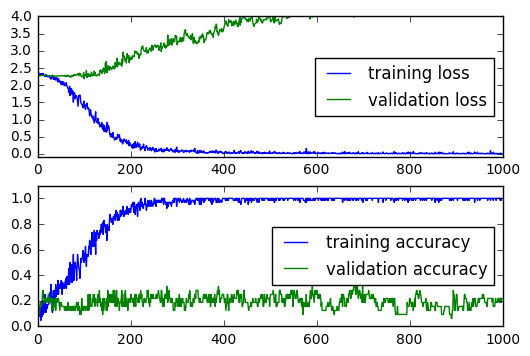

In [66]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[4]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[5]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.892176643111 		-0.038002746625 	0.00942747976482 	3.25497153402e-05 	


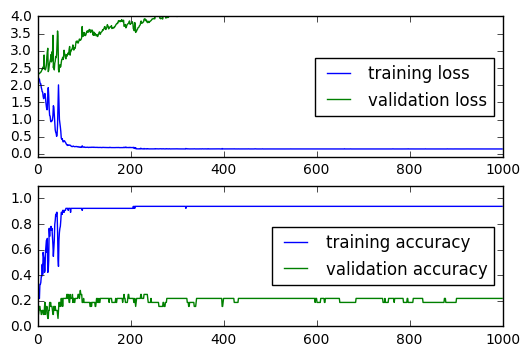

0.979837846594 		-0.0910293052206 	0.00326645740144 	-0.000388581281371 	


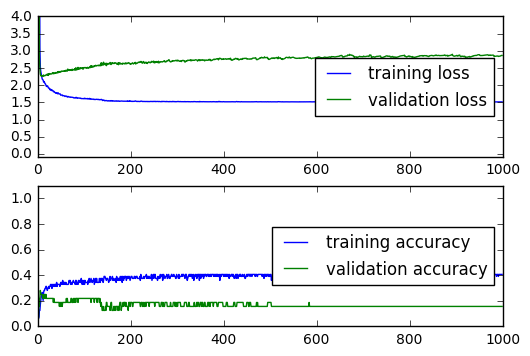

In [67]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[6]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[7]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.816173482257 		0.0300208208147 	0.00112421275857 	-2.97509444171e-05 	


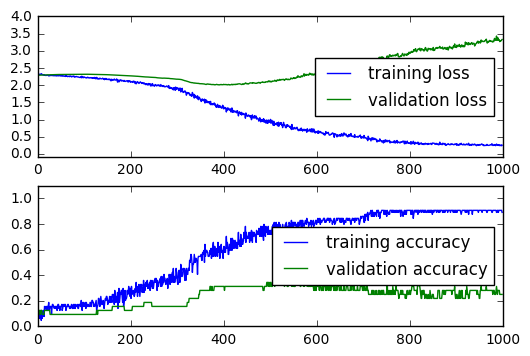

0.368308558508 		-0.00510973663454 	0.0078440396345 	0.00054539999069 	


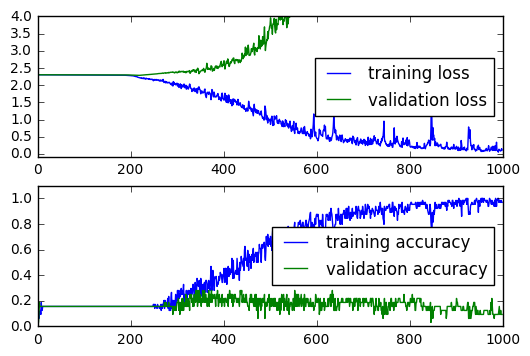

In [68]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[8]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[9]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.329513655809 		0.0191595556215 	0.00820061071902 	0.000420982111969 	


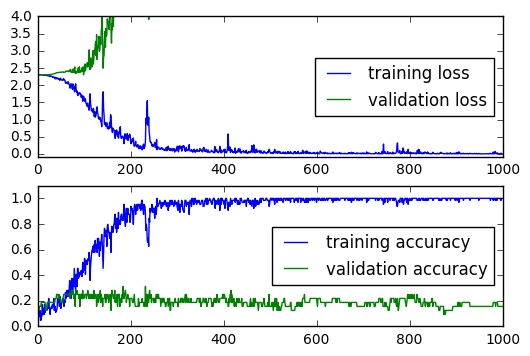

0.845100826714 		-0.0400516468265 	0.00922925602849 	-1.95839407519e-05 	


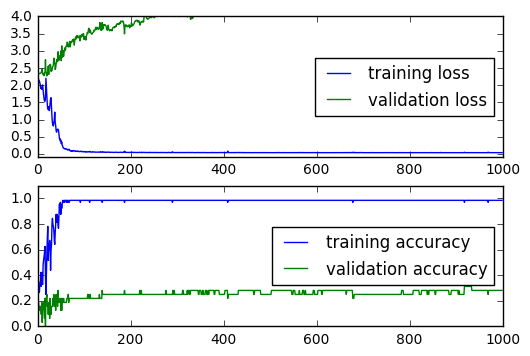

In [70]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[10]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[11]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.620394753598 		0.0377719661386 	0.00294830040321 	-0.000333445682234 	


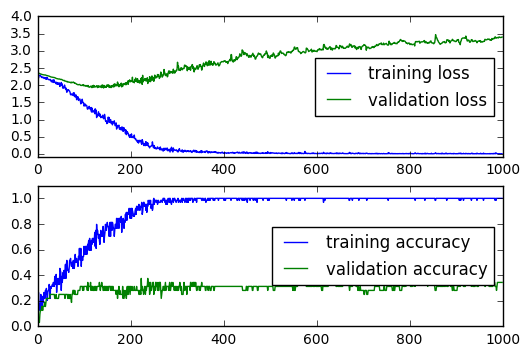

0.151408260861 		0.0694432584287 	0.00108717857246 	0.00070196795006 	


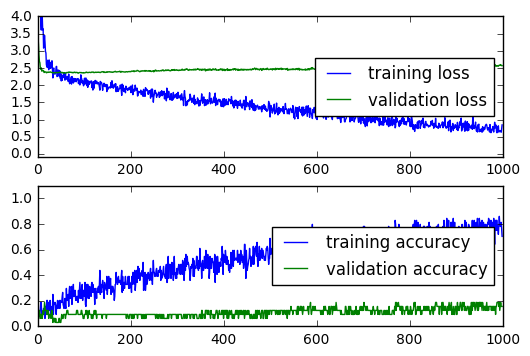

In [71]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[12]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[13]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.242263591197 		-0.0124325396034 	0.00277545603428 	0.000401703496366 	


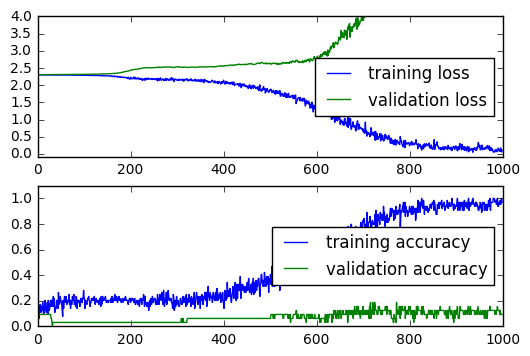

0.363557572002 		0.0764242735628 	0.00559337266691 	0.000718583547945 	


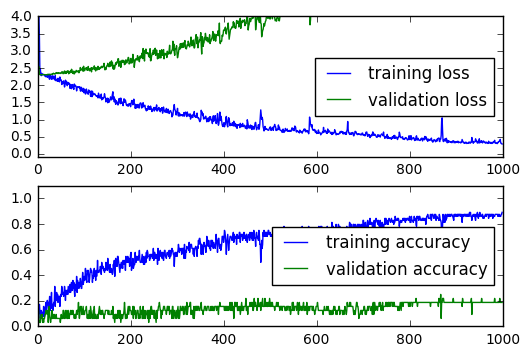

In [72]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[14]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[15]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.826253127653 		-0.0591371611619 	0.0031309138507 	0.000954065784625 	


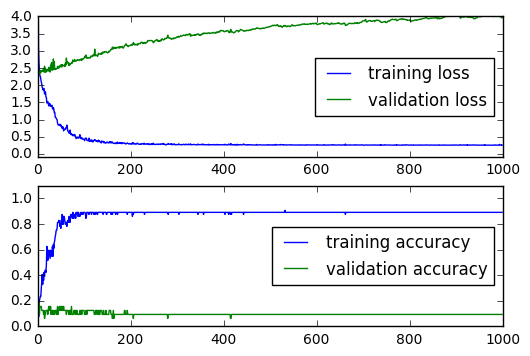

0.0469244880391 		0.0150243163296 	0.00272140664059 	0.000905834470006 	


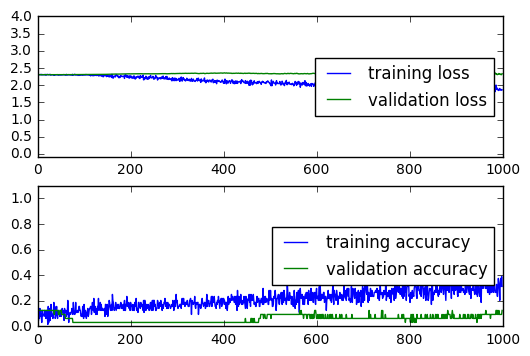

In [73]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[16]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[17]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

keep_prob		init mean		init std		learning rate
0.0730594253821 		0.0118729901082 	0.00574018601191 	-0.0001079757163 	


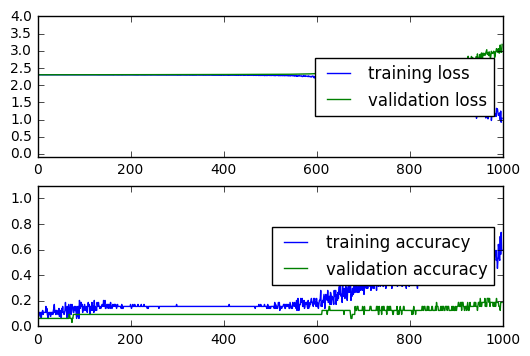

0.903352898368 		0.0114907535942 	0.00470064478244 	-0.000539822228505 	


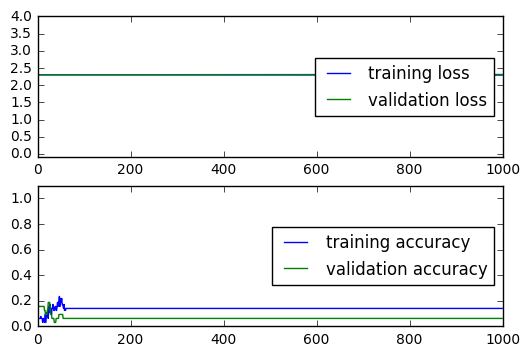

In [74]:
print 'keep_prob\t\t', 'init mean\t\t', 'init std\t\t', 'learning rate'
key = keys[18]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)
print "="*100
key = keys[19]
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t'
exp_data = experiment_data[key]
plot_data(exp_data)

***
### Summary
- Trail run parameters:
    - GradientDescentOptimizer
    - learning rate: 0.00032, decay rate: 0.5, decay steps: 100
    - Drop out keep prob: 0.5
    - Weights initialization: truncated_normal with mean=0.0, stddev=0.008
    - Biases initialization : constant (0.0)
    - CONVNET architecture:
        * conv1: filter size 5x5, num of filters: 32, stride=1, padding=SAME + ReLu
        * pool1: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv2: filter size 3x3, num of filters: 32, stride=1, padding=SAME + ReLu
        * pool2: filter size 2x2, max pooling, stride=2, padding=SAME
        * pool3: filter size 2x2, max pooling, stride=1, padding=SAME
        * fc1  : 256 neurons
        * fc2  : 10 neurons
    - Time cost per epoch: 27 secs
    - MiniBatch size: 512
    - Total epoches ran: 2000
    - Validation accuracy: ~53%; test accuracy: ~52%

***
### Analyze trail run data

In [3]:
trail_data = unpickle("training_data_stack1")

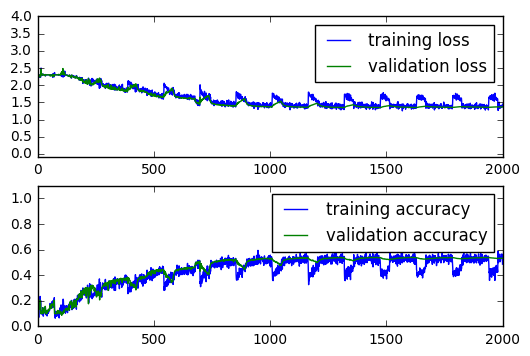

In [5]:
plot_data(trail_data)

In [10]:
print "Final Validation Accuracy: %.2f \t Test Accuracy: %.2f" %(trail_data['valid_acc'][-1], trail_data['test_acc'])

Final Validation Accuracy: 0.53 	 Test Accuracy: 0.52
